# 3 Exploratory Data Analysis

## Table of Contents:

* [3.1 Introduction](#3.1_Introduction)
* [3.2 Import Packages](#3.2_Import_Packages)
* [3.3 Load the Data](#3.3_Load_the_Data)
* [3.4 Exploring the Data](#3.4_Exploring_the_Data)
  * [3.4.1 Shifting the TAC Data](#3.4.1_Shifting_the_TAC_Data)
  * [3.4.2 Imputing the Missing Data](#3.4.2_Imputing_the_Missing_Data)
    * [3.4.2.1 Interpolation](#3.4.2.1_Interpolation)
    * [3.4.2.2 Triangular Moving Average](#3.4.2.2_Triangular_Moving_Average)
  * [3.4.3 Smoothing the Accelerometer Data](#3.4.3_Smoothing_the_Accelerometer_Data)
  * [3.4.4 Segmenting the Data](#3.4.4_Segmenting_the_Data)
  * [3.4.5 Featurizing the Accelerometer Data](#3.4.5_Featurizing_the_Accelerometer_Data)
  * [3.4.6 Investigating Features](#3.4.6_Investigating_Features)
* [3.5 Summary and Next Steps](#3.5_Summary_and_Next_Steps)

## 3.1 Introduction<a id='3.1_Introduction'></a>

From our Data Wrangling step, we had exported 13 CSV files of each participant's accelerometer data, transdermal alcohol content (TAC) data, and each instance's corresponding Unix Timestamp (note: the timestamp has 3 additional units, corresponding to milliseconds). The CSV files were titled in the format "pid[#]_acc_TAC.csv", where "#" ranges from 1 to 13, for the 13 anonymized individuals. We kept the NaN values in the exported CSV, giving us flexibility in this EDA step to determine how we want to shift the data, whether to interpolate, do a running average smoothing, etc. While trying different smoothing methods on the raw TAC data, we found that a rolling window of 1.5 or 2 hours and interpolating with quadratic or cubic methods are most promising of the methods we tried.

In this notebook, we will do the following:

1. __Shift the TAC data (subtract the 45-minute lag).__ This will align drinking activity (i.e. the phone accelerometer data) with changes in TAC.

2. __Smooth/Impute the data.__ Bifurcate the TAC data. With one set, interpolate with polynomial fitting, from the 3rd to the 7th degree. Look at a small window of NaNs and see how much the fitting changes between each change in degree. With the other set, we smooth with a triangular rolling window. Use the same smoothing methods with the accelerometer data.
  
3. __Segment the data__ into sections separated by at least two minutes of zero-data or missing readings in the accelerometer data. This will address the missing acceleromter entries.

4. __Featurize accelerometer x-, y-, and z-axis data__, for a total of 10-20 features. We do this for each bifurcated TAC dataset.

5. __Investigate relationships between features.__ Every feature will be investigated, using numerical and visual means such as PCA, heatmaps, box plots, and so forth.

## 3.2 Import Packages<a id='3.2_Import_Packages'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler

## 3.3 Load the Data<a id='3.3_Load_the_Data'></a>

In [2]:
# change directories to where the processed data is located.

path = 'data'
os.chdir(path)
os.getcwd()

'C:\\Users\\grace\\Documents\\Data Science Bootcamp\\DSC-projects\\Capstone 2\\Heavy drinking project\\data'

In [3]:
#Load the accelerometer and TAC data for participant 1. Verify it loaded correctly.
columns = ['time', 'x', 'y', 'z', 'TAC Level']
pid1 = pd.read_csv("pid1_acc_TAC.csv", usecols=columns)
pid1.head()

time       x       y       z  TAC Level
0  1493735870653  0.1261 -0.0078 -0.0243        NaN
1  1493735870679  0.1336 -0.0697 -0.0446        NaN
2  1493735870703  0.1443 -0.0474 -0.0447        NaN
3  1493735870729  0.1255 -0.0038  0.0111        NaN
4  1493735870753  0.1076  0.0032  0.0276        NaN

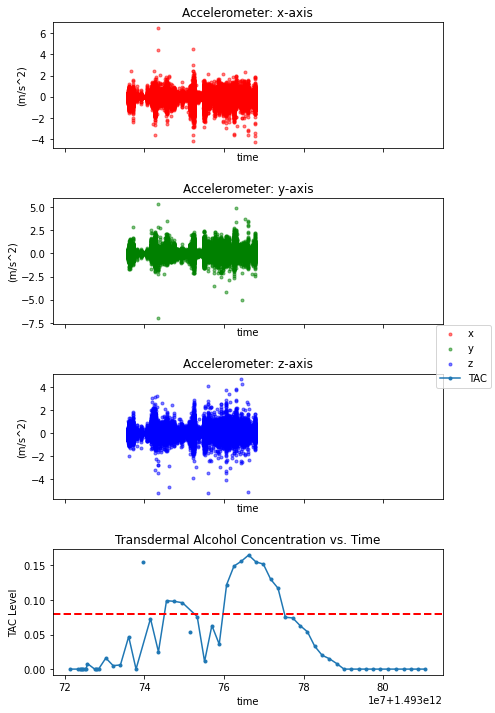

In [4]:
# Plot the accelerometer and TAC data.

def plot_acc_TAC(df, col_name='TAC Level'):
    """This function accepts a dataframe that has x, y, z, and TAC columns; and unix time column.
    It returns a graph that has the x, y, z subplots and TAC line plot as a 4-row subplot."""

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(7,12), sharex=True)

    ax1.scatter(df.time, df.x, label='x', marker='.', alpha=0.5, color='r')
    ax2.scatter(df.time, df.y, label='y', marker='.', alpha=0.5, color='g')
    ax3.scatter(df.time, df.z, label='z', marker='.', alpha=0.5, color='b')
    ax4.plot(df.time, df[col_name], label='TAC', linestyle='-', marker='.')

    ax4.axhline(y=0.08, linewidth=2, color='r', linestyle='--')

    fig.legend(loc='right')
    ax1.set_xlabel('time')
    ax2.set_xlabel('time')
    ax3.set_xlabel('time')
    ax4.set_xlabel('time')

    ax1.set_ylabel('(m/s^2)')
    ax2.set_ylabel('(m/s^2)')
    ax3.set_ylabel('(m/s^2)')
    ax4.set_ylabel('TAC Level')

    ax1.set_title('Accelerometer: x-axis')
    ax2.set_title('Accelerometer: y-axis')
    ax3.set_title('Accelerometer: z-axis')
    ax4.set_title('Transdermal Alcohol Concentration vs. Time')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

    plt.show()

    
# Plot the accelerometer and TAC data for Participant 1.
plot_acc_TAC(pid1)
#Note, this plot looks the same as in the Data Wrangling notebook. We have loaded the file correctly.

In [5]:
#Load the accelerometer and TAC data for participants 2 through 13.
columns = ['time', 'pid', 'x', 'y', 'z', 'TAC Level']
pid2 = pd.read_csv("pid2_acc_TAC.csv", usecols=columns)
pid3 = pd.read_csv("pid3_acc_TAC.csv", usecols=columns)
pid4 = pd.read_csv("pid4_acc_TAC.csv", usecols=columns)
pid5 = pd.read_csv("pid5_acc_TAC.csv", usecols=columns)
pid6 = pd.read_csv("pid6_acc_TAC.csv", usecols=columns)
pid7 = pd.read_csv("pid7_acc_TAC.csv", usecols=columns)
pid8 = pd.read_csv("pid8_acc_TAC.csv", usecols=columns)
pid9 = pd.read_csv("pid9_acc_TAC.csv", usecols=columns)
pid10 = pd.read_csv("pid10_acc_TAC.csv", usecols=columns)
pid11 = pd.read_csv("pid11_acc_TAC.csv", usecols=columns)
pid12 = pd.read_csv("pid12_acc_TAC.csv", usecols=columns)
pid13 = pd.read_csv("pid13_acc_TAC.csv", usecols=columns)

In [6]:
#Put all of the loaded data into an easily accessible list.
pid_list = [pid1, pid2, pid3, pid4, pid5, pid6, pid7, pid8, pid9, pid10, pid11, pid12, pid13]

At this point we have loaded all of our data for all 13 of our anonymized individuals.

## 3.4 Exploring the Data<a id='3.4_Exploring_the_Data'></a>

### 3.4.1 Shifting the TAC Data<a id='3.4.1_Shifting_the_TAC_Data'></a>

There is generally a 45-minute to 2-hour lag between alcohol ingestion and transdermal alcohol readings. According to the authors of this dataset, the manufacturer of the SCRAM bracelets used in this study state that there is an approximate 45-minute lag between alcohol entering the blood stream and the SCRAM device reporting the observation in the user's sweat. Other academic papers argue that this lag can extend up to 2-hours, depending on the individual's sex, weight, and number of drinks consumed. Due to our lack of identifying information on the individuals in this dataset, we will follow the authors' lead and shift the TAC data by 45-minutes.

In [7]:
#Every TAC output needs to be shifted by 45 minutes, or 2700 seconds.
#Since the 'time' column is in milliseconds, we need to shift everything back by 2,700,000 milliseconds.

def shift_45_minutes(df):
    """Copies the 'TAC Level' column and its corresponding unix timestamp, shifts it by 45 minutes
    (or 2,700,000 milliseconds), and appends it to the dataframe as a new column called 'TAC_shifted'.
    Deletes the original 'TAC Level' column."""
    TAC = df[['time','TAC Level']].dropna()
    acc = df[['time', 'x', 'y', 'z']].dropna()
    TAC_shifted = TAC.sub([2700000, 0], axis='columns') #subtract 2700000 millisec from time column
    TAC_renamed = TAC_shifted.rename(columns={"TAC Level": "TAC_shifted"}) #rename the column
    combined = pd.merge(acc, TAC_renamed, how='outer', on='time') #merge the two df's
    return combined

In [8]:
#Test out the 45-minute shift function with pid1.

pid1 = pd.read_csv("pid1_acc_TAC.csv", usecols=columns) #we keep this here to reset pid1 as needed.
pid1_shift = shift_45_minutes(pid1)
pid1_shift.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1225784 entries, 0 to 1225783
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   time         1225784 non-null  int64  
 1   x            1225727 non-null  float64
 2   y            1225727 non-null  float64
 3   z            1225727 non-null  float64
 4   TAC_shifted  57 non-null       float64
dtypes: float64(4), int64(1)
memory usage: 56.1 MB


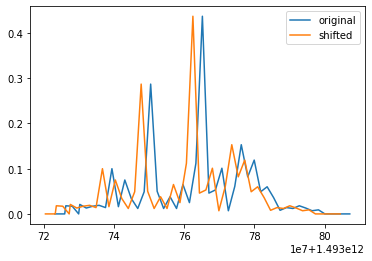

In [9]:
#Test out the 45-minute shift visually, with pid2.
pid2_shift = shift_45_minutes(pid2)
_=plt.plot(pid2.time, pid2['TAC Level'], label='original')
_=plt.plot(pid2_shift.time, pid2_shift.TAC_shifted, label='shifted')
_=plt.legend(loc='upper right')

In [10]:
#These lines of code can help to reset the dataframs prior to being shifted.
#remove the comments to run the lines of code.

#columns = ['time', 'pid', 'x', 'y', 'z', 'TAC Level']
#pid1 = pd.read_csv("pid1_acc_TAC.csv", usecols=columns)
#pid2 = pd.read_csv("pid2_acc_TAC.csv", usecols=columns)
#pid3 = pd.read_csv("pid3_acc_TAC.csv", usecols=columns)
#pid4 = pd.read_csv("pid4_acc_TAC.csv", usecols=columns)
#pid5 = pd.read_csv("pid5_acc_TAC.csv", usecols=columns)
#pid6 = pd.read_csv("pid6_acc_TAC.csv", usecols=columns)
#pid7 = pd.read_csv("pid7_acc_TAC.csv", usecols=columns)
#pid8 = pd.read_csv("pid8_acc_TAC.csv", usecols=columns)
#pid9 = pd.read_csv("pid9_acc_TAC.csv", usecols=columns)
#pid10 = pd.read_csv("pid10_acc_TAC.csv", usecols=columns)
#pid11 = pd.read_csv("pid11_acc_TAC.csv", usecols=columns)
#pid12 = pd.read_csv("pid12_acc_TAC.csv", usecols=columns)
#pid13 = pd.read_csv("pid13_acc_TAC.csv", usecols=columns)

#pid_list = [pid1, pid2, pid3, pid4, pid5, pid6, pid7, pid8, pid9, pid10, pid11, pid12, pid13]

In [11]:
#shift all of the TAC data by 45 minutes, for all 13 individuals.

for i in range(13):
    pid_list[i] = shift_45_minutes(pid_list[i])

#Note: this affects pid1 through pid13 in the "pid_list" list. 
#But it does not affect the earlier pid1-pid13 dataframes not in the list.

#Let's make individual shifted dataframes.
pid1_shift = pid_list[0]
pid2_shift = pid_list[1]
pid3_shift = pid_list[2]
pid4_shift = pid_list[3]
pid5_shift = pid_list[4]
pid6_shift = pid_list[5]
pid7_shift = pid_list[6]
pid8_shift = pid_list[7]
pid9_shift = pid_list[8]
pid10_shift = pid_list[9]
pid11_shift = pid_list[10]
pid12_shift = pid_list[11]
pid13_shift = pid_list[12]

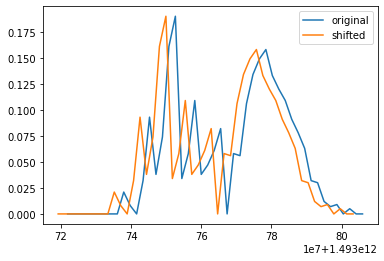

In [12]:
#verify this works for pid4 in the pid_list.
pid4_shift = pid_list[3]
_=plt.plot(pid4.time, pid4['TAC Level'], label='original')
_=plt.plot(pid4_shift.time, pid4_shift.TAC_shifted, label='shifted')
_=plt.legend(loc='upper right')

### 3.4.2 Imputing the Missing Data<a id='3.4.2_Imputing_the_Missing_Data'></a>

In the previous notebook (Data Wrangling), while trying different smoothing methods on the raw TAC data, we found that a rolling window of 1.5 or 2 hours and interpolating with quadratic or cubic methods appeared to be promising.

In this step, we will bifurcate the data and impute the missing TAC data. We will either interpolate it with polynomial fitting smooth it with a triangular moving average (followed by interpolating with a polynomial fitting). 
 * We will use scipy interpolate() method in order to interpolate with polynomial fitting of varying degrees.
 * We will use the pandas rolling() method for triangular moving average to smooth, followed by interpolation to impute the missing data.

For interpolating (without TMA), we will try polynomial fitting from the 3rd to the 9th degree.  We can observe how much the fitting changes between each change in degree by plotting a small window of NaN's.

Triangular moving average (TMA) is averaged twice, so it places more weight on the middle portion of the data. For the TMA, we'll use a rolling window of 1.5 hours (i.e. 3 data points). Since many of the rows with accelerometer values will still read NaN in the TAC column, we can impute those TAC values using a linear interpolation of the TAC data. 

At the end of this section, we should have the following in each dataframe:
 * Columns with TAC values interpolated by polynomial fitting where degree = 3, 5, 7, 9.
 * Column with TAC values smoothed by TMA (window = 3, corresponding to 1.5 hours), followed by cubic (3rd degree) interpolation.


#### 3.4.2.1 Interpolation<a id='3.4.2.1_Interpolation'></a>

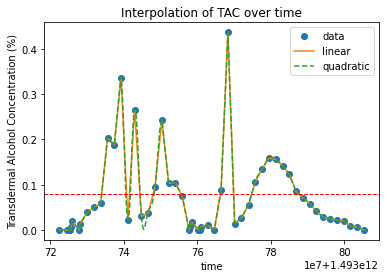

In [13]:
#Separate the TAC data as a numpy array, and use scipy.interpolate function interp1d.

from scipy.interpolate import interp1d

def polynomial_smooth_plot(df, col_name = 'TAC_shifted'):
    '''This function takes the specified column from the dataframe, converts it to a numpy array, and 
    interpolates it with scipy.interpolate interp1d, kind = linear, quadratic, cubic. 
    The results are displayed in a graph.'''
    
    df_sorted = df.sort_values(by='time').reset_index(drop=True) #keep all NaN values. Use this for prediction.
    df_clean = df_sorted[['time', col_name]].dropna() #drop all NaN values. Use this for training.
    
    x = df_clean['time'].to_numpy()
    y = df_clean[col_name].to_numpy()
    xnew = df_sorted['time'].to_numpy()

    f = interp1d(x, y)
    f2 = interp1d(x, y, kind='quadratic')
    f3 = interp1d(x, y, kind='cubic')
    
    plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
    plt.legend(['data', 'linear', 'quadratic'], loc='best')
    plt.xlabel('time')
    plt.ylabel('Transdermal Alcohol Concentration (%)')
    plt.axhline(y=0.08, linewidth=1, linestyle='--', color='r')
    plt.title('Interpolation of TAC over time')
    plt.show()

#test with pid13_shift
polynomial_smooth_plot(pid13_shift)

In [14]:
#Same as above, but return a pandas dataframe with the results as columns.

def polynomial_smooth(df, col_name = 'TAC_shifted'):
    '''This function takes the specified column from the dataframe, converts it to a numpy array, and 
    interpolates it with scipy.interpolate interp1d. Degree/Order is specified as 3, 5, 7, 9. 
    This returns a pandas dataframe with each interpolation as a column.'''
    
    df_sorted = df.sort_values(by='time').reset_index(drop=True) #keep all NaN values. Use this for prediction.
    
    #Note: pid3_shift has issue where the accelerometer data goes on longer than the TAC data, 
    #and we get an error later in the code ("A value in x_new is above the interpolation range.")
    #Therefore, we need to drop all the rows after the end of the TAC data.
    max_TAC_time = max(df_sorted[['time', col_name]].dropna()['time'])
    ending_index = df_sorted[df_sorted.time == max_TAC_time].index[0] + 1 #index starts at 0, make sure to +1
    df_trimmed = df_sorted.copy()
    df_trimmed = df_trimmed[0:ending_index]
    
    df_clean = df_trimmed[['time', col_name]].dropna() #drop all NaN values. Use this for training.

    
    x = df_clean['time'].to_numpy()
    y = df_clean[col_name].to_numpy()
    xnew = df_trimmed['time'].to_numpy() #use df_trimmed instead of df_sorted, to ensure xnew is within range.
    
    order = [3, 5, 7, 9]
    
    for i in order:
        f = interp1d(x, y, kind=i)
        df_trimmed['order_'+str(i)] = f(xnew)

    
    df_drop_raw = df_trimmed.drop(columns=[col_name]) #drop the original column
#    df_results = df_drop_raw.dropna() #drops all NaN values. Keeps only the rows with accelerometer data.
#    return df_results
    return df_drop_raw


test = polynomial_smooth(pid13_shift).dropna()
test.info() #check to see there are no NaN values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 662949 entries, 14 to 662994
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   time     662949 non-null  int64  
 1   x        662949 non-null  float64
 2   y        662949 non-null  float64
 3   z        662949 non-null  float64
 4   order_3  662949 non-null  float64
 5   order_5  662949 non-null  float64
 6   order_7  662949 non-null  float64
 7   order_9  662949 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 45.5 MB


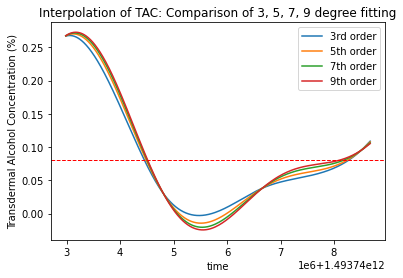

In [15]:
#Using the 'test' dataframe from earlier, take a section with lots of accelerometer data
#(and therefore where the TAC data used to be NaN values)
#and see how the interpolation differs between 3rd, 5th, 7th, and 9th degree.

x=test.time[150000:370000]
y1=test.order_3[150000:370000]
y2=test.order_5[150000:370000]
y3=test.order_7[150000:370000]
y4=test.order_9[150000:370000]
_=plt.plot(x, y1, '-', x, y2, '-', x, y3, '-', x, y4, '-')
_=plt.legend(['3rd order', '5th order', '7th order', '9th order'], loc='best')
_=plt.xlabel('time')
_=plt.ylabel('Transdermal Alcohol Concentration (%)')
_=plt.title('Interpolation of TAC: Comparison of 3, 5, 7, 9 degree fitting')
_=plt.axhline(y=0.08, linewidth=1, linestyle='--', color='r')
_=plt.show()

We see here there are slight differences in the interpolated TAC values between 3, 5, 7, and 9 degree interpolations. It does not appear to be significantly different from each other, though we will keep them to determine later which degree was the optimal fitting when we use our classifier model, to predict when someone is legally drunk (TAC >= 0.08) or not (TAC < 0.08). 

The triangular moving average will likely produce a significantly different result as we do a rolling TMA prior to interpolating.

Note: If you play around with the ranges that you plot, you would find certain jagged sections of the plot where it appears no interpolation occured. This is due to dropping the NaN values after running our polynomial_smooth() function. If you were to run plot_acc_TAC() on the dataframe, you would find that the interpolation is only smooth where there is abundant accelerometer data.

In [16]:
#We use our polynomial_smooth() function on all of the shifted datasets to interpolate.

pid1_interpolate = polynomial_smooth(pid1_shift).dropna()
pid2_interpolate = polynomial_smooth(pid2_shift).dropna()
pid3_interpolate = polynomial_smooth(pid3_shift).dropna()
pid4_interpolate = polynomial_smooth(pid4_shift).dropna()
pid5_interpolate = polynomial_smooth(pid5_shift).dropna()
pid6_interpolate = polynomial_smooth(pid6_shift).dropna()
pid7_interpolate = polynomial_smooth(pid7_shift).dropna()
pid8_interpolate = polynomial_smooth(pid8_shift).dropna()
pid9_interpolate = polynomial_smooth(pid9_shift).dropna()
pid10_interpolate = polynomial_smooth(pid10_shift).dropna()
pid11_interpolate = polynomial_smooth(pid11_shift).dropna()
pid12_interpolate = polynomial_smooth(pid12_shift).dropna()
pid13_interpolate = polynomial_smooth(pid13_shift).dropna()

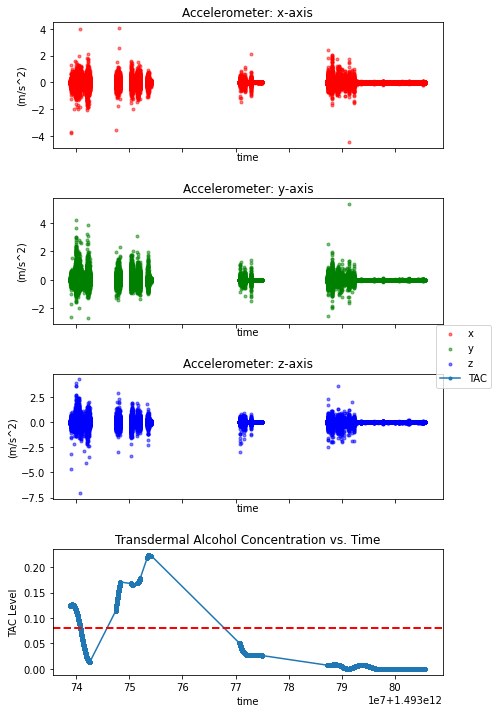

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117017 entries, 18 to 1117068
Data columns (total 8 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   time     1117017 non-null  int64  
 1   x        1117017 non-null  float64
 2   y        1117017 non-null  float64
 3   z        1117017 non-null  float64
 4   order_3  1117017 non-null  float64
 5   order_5  1117017 non-null  float64
 6   order_7  1117017 non-null  float64
 7   order_9  1117017 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 76.7 MB
None


In [17]:
#Check that this worked. 
#Use pid6, as the original raw data had accelerometer data longer than the TAC data, 
#and it has many gaps in the data.
plot_acc_TAC(pid6_interpolate, col_name = 'order_3')
print(pid6_interpolate.info())

#### 3.4.2.2 Triangular Moving Average<a id='3.4.2.2_Triangular_Moving_Average'></a>

Using our shifted data (pid#_shift), we smooth the TAC data by calculating the TMA (window = 3, corresponding to 1.5 hours), followed by cubic (3rd degree) interpolation.

In [18]:
def tma_smooth(df, col_name = 'TAC_shifted'):
    '''This function takes the specified column from the dataframe, uses the pandas rolling() 
    function to smooth the TAC_shifted column using a triangular moving average (TMA), window size 3.
    This is followed by an interpolation of a cubic fitting.'''
    
    df_sorted = df.sort_values(by='time').reset_index(drop=True) #keep all NaN values. Use this for prediction.
    max_TAC_time = max(df_sorted[['time', col_name]].dropna()['time'])
    ending_index = df_sorted[df_sorted.time == max_TAC_time].index[0] + 1 #index starts at 0, make sure to +1
    df_trimmed = df_sorted.copy()
    df_trimmed = df_trimmed[0:ending_index]
    
    df_clean = df_trimmed[['time', col_name]].dropna() #drop all NaN values. Use this for training.
    df_tma = df_clean[col_name].rolling(3, center=True, win_type='triang').mean() #use triangular moving average
    df_tma_np = df_tma.to_numpy()
    
    df_tma_np[0] = df_clean[col_name].iloc[0]
    df_tma_np[-1] = df_clean[col_name].iloc[-1]
    
    x = df_clean['time'].to_numpy()
    y = df_tma_np
    xnew = df_trimmed['time'].to_numpy() 

    f = interp1d(x, y, kind=3) #cubic interpolation
    df_trimmed['tma'] = f(xnew)

    
    df_drop_raw = df_trimmed.drop(columns=[col_name]) #drop the original column
#    df_results = df_drop_raw.dropna() #drops all NaN values. Keeps only the rows with accelerometer data.
#    return df_results
    return df_drop_raw

tma_test = tma_smooth(pid4_shift)
tma_test.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591358 entries, 18 to 591393
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    591358 non-null  int64  
 1   x       591358 non-null  float64
 2   y       591358 non-null  float64
 3   z       591358 non-null  float64
 4   tma     591358 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 27.1 MB


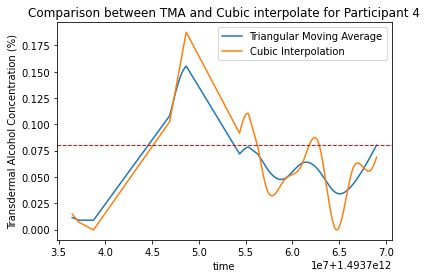

In [19]:
#do a small comparison between the tma smooth and regular interpolation
#compare pid4 data with TMA vs cubic interpolation.
_=plt.plot(tma_test.dropna().time, tma_test.dropna().tma)
_=plt.plot(pid4_interpolate.time, pid4_interpolate.order_3)
_=plt.legend(['Triangular Moving Average', 'Cubic Interpolation'], loc='best')
_=plt.xlabel('time')
_=plt.ylabel('Transdermal Alcohol Concentration (%)')
_=plt.title('Comparison between TMA and Cubic interpolate for Participant 4')
_=plt.axhline(y=0.08, linewidth=1, linestyle='--', color='r')
_=plt.show()

The jaggedness in the data for participant 4 reflects the missing accelerometer data. In the latter half of the plot, where the accelerometer data is more prominent, we can see more clearly the differences in just interpolation versus running a triangular moving average prior to interpolation.

In [20]:
#run TMA smooth on every pid#_shift, and append the TMA data to the interpolate data
pid1_interpolate['tma'] = tma_smooth(pid1_shift).dropna()['tma']
pid2_interpolate['tma'] = tma_smooth(pid2_shift).dropna()['tma']
pid3_interpolate['tma'] = tma_smooth(pid3_shift).dropna()['tma']
pid4_interpolate['tma'] = tma_smooth(pid4_shift).dropna()['tma']
pid5_interpolate['tma'] = tma_smooth(pid5_shift).dropna()['tma']
pid6_interpolate['tma'] = tma_smooth(pid6_shift).dropna()['tma']
pid7_interpolate['tma'] = tma_smooth(pid7_shift).dropna()['tma']
pid8_interpolate['tma'] = tma_smooth(pid8_shift).dropna()['tma']
pid9_interpolate['tma'] = tma_smooth(pid9_shift).dropna()['tma']
pid10_interpolate['tma'] = tma_smooth(pid10_shift).dropna()['tma']
pid11_interpolate['tma'] = tma_smooth(pid11_shift).dropna()['tma']
pid12_interpolate['tma'] = tma_smooth(pid12_shift).dropna()['tma']
pid13_interpolate['tma'] = tma_smooth(pid13_shift).dropna()['tma']

In [21]:
#check to see if the previous step worked
pid10_interpolate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631303 entries, 18 to 631346
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   time     631303 non-null  int64  
 1   x        631303 non-null  float64
 2   y        631303 non-null  float64
 3   z        631303 non-null  float64
 4   order_3  631303 non-null  float64
 5   order_5  631303 non-null  float64
 6   order_7  631303 non-null  float64
 7   order_9  631303 non-null  float64
 8   tma      631303 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 48.2 MB


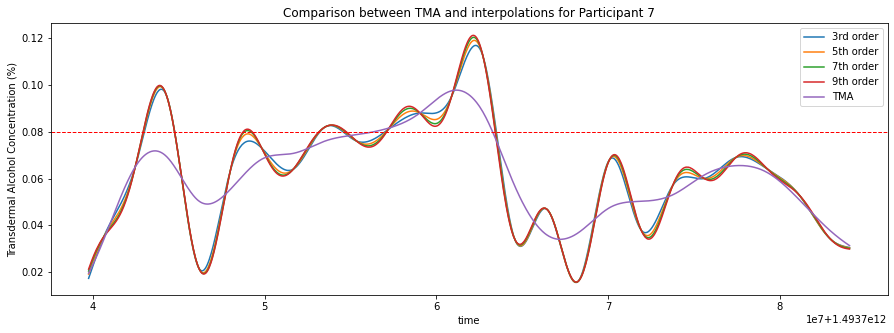

In [22]:
#try plotting and comparing TMA and the other interpolations
fig, ax = plt.subplots(figsize=(15,5))
df=pid7_interpolate
_=plt.plot(df.time, df.order_3, df.time, df.order_5, df.time, df.order_7, df.time, df.order_9, df.time, df.tma)
_=plt.legend(['3rd order', '5th order', '7th order', '9th order', 'TMA'], loc='best')
_=plt.xlabel('time')
_=plt.ylabel('Transdermal Alcohol Concentration (%)')
_=plt.title('Comparison between TMA and interpolations for Participant 7')
_=plt.axhline(y=0.08, linewidth=1, linestyle='--', color='r')
_=plt.show()

In this last plot we can more clearly see the difference between strictly interpolating the TAC datavalues, and running a Triangular Moving Average followed by interpolating (of the 3rd order). We can expect to see more varying results between the interpolated data and the TMA data when we try predicting with our models.

### 3.4.3 Smoothing the Accelerometer Data<a id='3.4.3_Smoothing_the_Accelerometer_Data'></a>

Similarly to how we smoothed the TAC data, we should also smooth the accelerometer data. The authors of the dataset using the same low-pass filter on both the TAC and accelerometer data, but in a 2010 paper ("Activity Recognition using Cell Phone Accelerometers", J.R. Kwapisz, G.M. Weiss, S.A. Moore, DOI: 10.1145/1964897.1964918) we see the authors use the raw accelerometer data.

For the Triangular Moving Average (TMA) TAC data, we will also use TMA to smooth the accelerometer data. For the interpolated data, since nothing was actually smoothed/averaged and we simply imputed the NaN values, we will keep the raw accelerometer data.

For consistency and simplicity, we use the same TMA with window size 3 to smooth the accelerometer data. Possibly in a future project we can automate this process to optimize the smoothing method, window size, interpolation, etc. 

In [23]:
def tma_acc(df):
    """This function takes the x, y, and z columns from the dataframe, uses the pandas rolling() 
    function to smooth the TAC_shifted column using a triangular moving average (TMA), window size 3.
    The original dataframe is return with these new columns appended."""

    df_copy = df.reset_index(drop=True) #reset index so we can select the first and last rows by index
   
    df_copy['x_tma'] = df_copy.x.rolling(3, center=True, win_type='triang').mean()
    df_copy['y_tma'] = df_copy.y.rolling(3, center=True, win_type='triang').mean()
    df_copy['z_tma'] = df_copy.z.rolling(3, center=True, win_type='triang').mean()
        
    #after averaging, our first and last rows are NaN values.
    #impute the the first and last rows with the raw accelerometer data.

    df_copy.iloc[0,9] = df.x.iloc[0]
    df_copy.iloc[-1,9] = df.x.iloc[-1]
    
    df_copy.iloc[0,10] = df.y.iloc[0]
    df_copy.iloc[-1,10] = df.y.iloc[-1]
    
    df_copy.iloc[0,11] = df.z.iloc[0]
    df_copy.iloc[-1,11] = df.z.iloc[-1]
    
    return df_copy

In [24]:
# test to see if it works
pid2_tma = tma_acc(pid2_interpolate)
pid2_tma.head()

time       x       y       z   order_3   order_5   order_7  \
0  1493737404780 -0.0094  0.0147  0.0186  0.077353  0.076486  0.074826   
1  1493737404807 -0.0001  0.0126  0.0168  0.077352  0.076484  0.074824   
2  1493737404830  0.0091  0.0017  0.0164  0.077350  0.076483  0.074823   
3  1493737404857  0.0088 -0.0004  0.0177  0.077349  0.076482  0.074821   
4  1493737404881  0.0088  0.0039  0.0119  0.077347  0.076480  0.074820   

    order_9      tma     x_tma   y_tma     z_tma  
0  0.075057  0.05739 -0.009400  0.0147  0.018600  
1  0.075055  0.05739 -0.000125  0.0104  0.017150  
2  0.075054  0.05739  0.006725  0.0039  0.016825  
3  0.075052  0.05739  0.008875  0.0012  0.015925  
4  0.075051  0.05739  0.009250  0.0037  0.012650

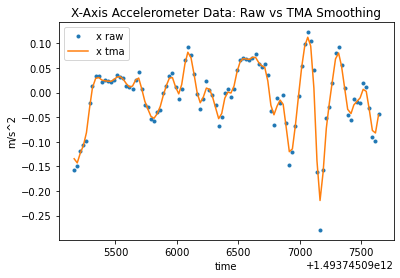

In [25]:
df=pid2_tma[40000:40100]
_=plt.plot(df.time, df.x, '.', df.time, df.x_tma, '-' )
_=plt.legend(['x raw', 'x tma'], loc='best')
_=plt.xlabel('time')
_=plt.ylabel('m/s^2')
_=plt.title('X-Axis Accelerometer Data: Raw vs TMA Smoothing')
_=plt.show()

In [26]:
#run TMA smooth on the accelerometer columns of every pid#_shift
pid1_tma = tma_acc(pid1_interpolate)
pid2_tma = tma_acc(pid2_interpolate)
pid3_tma = tma_acc(pid3_interpolate)
pid4_tma = tma_acc(pid4_interpolate)
pid5_tma = tma_acc(pid5_interpolate)
pid6_tma = tma_acc(pid6_interpolate)
pid7_tma = tma_acc(pid7_interpolate)
pid8_tma = tma_acc(pid8_interpolate)
pid9_tma = tma_acc(pid9_interpolate)
pid10_tma = tma_acc(pid10_interpolate)
pid11_tma = tma_acc(pid11_interpolate)
pid12_tma = tma_acc(pid12_interpolate)
pid13_tma = tma_acc(pid13_interpolate)

### 3.4.4 Segmenting the Data<a id='3.4.4_Segmenting_the_Data'></a>

There are segments of the accelerometer data with zero-data or missing readings. The authors of the dataset indicate that it may have been due to occasional periods of lost internet connection or loss of battery power. 

In this section, we split each participant's dataset into segments separated by at least two minutes (120 seconds, or 120,000 milliseconds) of zero-data or NaN values in the accelerometer data (x, y, and z axes). 

In [27]:
# Let us first check the raw accelerometer data (x, y, z) whether there is any instance where 0's is recorded
# in all 3 axes. This would indicate times where the participant was not moving, or the phone was laid flat, 
# and these sections may need to be dropped since it does not give us information on a person's movement and its
# subsequent relationship to alcohol concentration.

pid_tma_list = [pid1_tma, pid2_tma, pid3_tma, pid4_tma, pid5_tma, pid6_tma, \
                pid7_tma, pid8_tma, pid9_tma, pid10_tma, pid11_tma, pid12_tma, pid13_tma]

for i in range(13):
    df = pid_tma_list[i]
    zeroes = len(df.loc[(df.x == 0) & (df.y==0) & (df.z==0)])
    print("PID", i+1, ":", zeroes)

PID 1 : 0
PID 2 : 0
PID 3 : 0
PID 4 : 2
PID 5 : 0
PID 6 : 7
PID 7 : 0
PID 8 : 0
PID 9 : 0
PID 10 : 2
PID 11 : 2
PID 12 : 0
PID 13 : 1


In [28]:
#PID 6 had the most instances with 0's. Check to see if these values are adjacent to each other. 
df=pid6_tma
df.loc[(df.x == 0) & (df.y==0) & (df.z==0)]

#From here, we see that each of these rows are separated by 26 seconds or more. 
#The accelerometer reading 0's is just a coincidence.

time    x    y    z   order_3   order_5   order_7   order_9  \
250657  1493771602313 -0.0 -0.0 -0.0  0.031423  0.027850  0.026068  0.025117   
251702  1493771628557  0.0  0.0  0.0  0.031135  0.027574  0.025788  0.024833   
269907  1493772085865  0.0 -0.0 -0.0  0.027930  0.025593  0.024299  0.023570   
272074  1493772140281  0.0  0.0 -0.0  0.027734  0.025636  0.024460  0.023794   
277148  1493772267708 -0.0 -0.0  0.0  0.027386  0.025887  0.025023  0.024527   
282746  1493772408319  0.0  0.0 -0.0  0.027147  0.026343  0.025865  0.025588   
289399  1493772575372 -0.0 -0.0 -0.0  0.026998  0.027014  0.027024  0.027030   

             tma     x_tma     y_tma     z_tma  
250657  0.045316 -0.000125 -0.000075 -0.000125  
251702  0.044926 -0.000175  0.000025 -0.000025  
269907  0.038509 -0.000500 -0.000250  0.000025  
272074  0.037811 -0.000200  0.000000 -0.000175  
277148  0.036247 -0.000150  0.000250 -0.000175  
282746  0.034654 -0.000150 -0.000225 -0.000200  
289399  0.032968 -0.000600 -0.000200  0.000200

In [29]:
#Now, find the indices of the rows where its succeeding row occurs 2 or more minutes later (i.e. 120 seconds later)
def two_minute_gap(df):
    """Finds rows where the succeeding row occurs 2-minute or later. Returns the indices of those rows."""
    comparison = df[['tma','time']].copy()
    comparison['time_diff'] = df['time'].diff()
    index_list = list(comparison.loc[comparison.time_diff > 120000].index) #120,000 milliseconds
    return index_list

In [30]:
print('Row Indices for >= 2-minute gap: ')
for i in range(13):
    df = pid_tma_list[i]
    index_list = two_minute_gap(df)
    print("PID", i+1, ":", index_list)
    print("PID", i+1, " list length:", len(index_list))
    print()

Row Indices for >= 2-minute gap: 
PID 1 : [452526]
PID 1  list length: 1

PID 2 : [23915, 344543, 353534, 407479]
PID 2  list length: 4

PID 3 : [182065, 182638, 198635, 208610, 217517, 247662, 262076, 289733, 304747, 306749, 308751, 322737, 327632, 333581, 347588, 447669, 530729, 745734, 767601, 790691, 823096, 823248]
PID 3  list length: 22

PID 4 : [15412, 15644, 15972, 79906, 114869]
PID 4  list length: 5

PID 5 : [86902, 167815]
PID 5  list length: 2

PID 6 : [136856, 166822, 182803, 202783, 214767, 215766, 382590]
PID 6  list length: 7

PID 7 : []
PID 7  list length: 0

PID 8 : [101828, 160746, 162744, 305969]
PID 8  list length: 4

PID 9 : [21976, 124820, 231708, 242696]
PID 9  list length: 4

PID 10 : [12979, 155825, 428532, 485471, 488466]
PID 10  list length: 5

PID 11 : [207753, 298629, 347580, 349578, 416496, 545338]
PID 11  list length: 6

PID 12 : [28048, 28317, 28333, 63748, 74227, 78219, 98177, 125118, 127114, 136096, 142084, 252337, 306224]
PID 12  list length: 13

PID

Aside from participant 7, all other participants have one or more instances of a 2-minute gap or longer of missing data. We will use these indices as the splitting point for each dataset. We save these datasets into smaller dataframes. For example, participant 1 has one index corresponding to a >= 2-minute gap. Using this index, we will split "pid1_tma" into 2 dataframes: "pid1_tma_1" and "pid1_tma_2".  

By segmenting the data in this manner, we can featurize these sub dataframes without concern for gaps in time.

In [31]:
#Note: the index list for each participant refers to the index of the first instance after the >=2-minute gap in data.
#Since some df's have as much as 22 gaps, make a function that will auto segment the data for us.

def segment_data(df):
    """Uses the 'two_minute_gap' function to find a list of indices where there is a gap of 2-minute or more in the data.
    Then, front that list, divide the dataframe into segments and append this to a list. Return the list."""
    
    index_list = two_minute_gap(df)
    
    if len(index_list) == 0:
        df_list = [df]
    else:
        df_list = [df[:index_list[0]]] #first segment

        for i in range(len(index_list)-1):    
            start = index_list[i]
            end = index_list[i+1]
            df_list.append(df[start:end]) #middle segments

        last_index = index_list[len(index_list)-1]
        df_list.append(df[last_index:]) #last segment

    return df_list

In [32]:
pid1_segment_list = segment_data(pid1_tma)

#check to see if this worked. indices should match.
print(two_minute_gap(pid1_tma))
pid1_segment_list[1].head(1)

#indices do match. We have the split at index 452526 for participant 1.

[452526]


time       x       y       z   order_3   order_5   order_7  \
452526  1493748248465  0.0387  0.0812  0.0214  0.058354  0.056055  0.054296   

         order_9       tma  x_tma  y_tma     z_tma  
452526  0.052712  0.073613  0.005   0.09 -0.032075

In [33]:
#segment the data for all 13 of the participants.
pid1_segment_list = segment_data(pid1_tma)
pid2_segment_list = segment_data(pid2_tma)
pid3_segment_list = segment_data(pid3_tma)
pid4_segment_list = segment_data(pid4_tma)
pid5_segment_list = segment_data(pid5_tma)
pid6_segment_list = segment_data(pid6_tma)
pid7_segment_list = segment_data(pid7_tma)
pid8_segment_list = segment_data(pid8_tma)
pid9_segment_list = segment_data(pid9_tma)
pid10_segment_list = segment_data(pid10_tma)
pid11_segment_list = segment_data(pid11_tma)
pid12_segment_list = segment_data(pid12_tma)
pid13_segment_list = segment_data(pid13_tma)

### 3.4.5 Featurizing the Accelerometer Data<a id='3.4.5_Featurizing_the_Accelerometer_Data'></a>

From Killian et al. (2019) (the authors of this dataset) and Kwapisz et al. (2010), both used a 10-second window to featurize the accelerometer data. In fact, Killian et al. found that the 10-second window performed best in terms of accuracy compared to other window lengths. We can optimize this window size in the future, but for now the 10-second window will be our starting point.

There are many different ways to featurize the accelerometer data. Because we have x, y, z, x_tma, y_tma, and z_tma axes, our features would be in 6's (twice-triplicate). Some features we can extract from each window of the accelerometer data are:
 * Mean
 * Standard Deviation
 * Median
 * Zero Crossing Rate - the number of times the signal changes signs.
 * Max (of raw and of absolute signal)
 * Min (of raw and of absolute signal)
 * Gait stretch - the difference between max and min of one stride (of raw signal).
 * Number of steps - the total number of peaks.
 * Step Time - the average time between steps.
 * RMS - Root-mean-square of accelerations, i.e. the average power.
 * Average Resultant Acceleration - Average of the square roots of the sum of the values of each axis squared: $\sqrt{x^{2} + y^{2} + z^{2}}$

We can use the pandas .rolling() function in combination with .mean(), .std(), etc. to make new columns with features.

In [34]:
# First we must convert the indexes back into datetime indexes.
# This will allow us to us the pandas rolling function to featurize 10-second windows,
# regardless of the number of instances in each window.

def convert_datetime(df):
    """Converts the 'time' column from int64 to datetime64, then sets the datetime column as index.
    The input can be a single dataframe or list of dataframes (i.e. an output from segment_data() function.)"""
    if type(df) == list: #if df is a standalone df, then this section is skipped.
        df_copy = []
        for i in range(len(df)): #convert int to datetime segment-by-segment
            df_copy.append(df[i].copy()) #this removes the SettingWithCopyWarning by using .copy()
            dt = pd.to_datetime(df[i]['time'], unit='ms', origin='unix').to_numpy()
            df_copy[i].loc[:,'time'] = dt
            df_copy[i] = df_copy[i].set_index('time')
    else:
        df_copy = df.copy()
        dt = pd.to_datetime(df['time'], unit='ms', origin='unix').to_numpy()
        df_copy.loc[:,'time'] = dt
    return df_copy

test = convert_datetime(pid1_segment_list.copy()) #test on a copy so as not to modify the original
test[0].tail()

x       y       z   order_3   order_5   order_7  \
time                                                                            
2017-05-02 17:50:22.587 -0.1667 -0.2350 -0.2345  0.082020  0.079929  0.077814   
2017-05-02 17:50:22.612 -0.1215 -0.0444 -0.6633  0.082019  0.079928  0.077814   
2017-05-02 17:50:22.637 -0.0633  0.0304 -0.6347  0.082018  0.079928  0.077813   
2017-05-02 17:50:22.662 -0.1299  0.0888 -0.2392  0.082017  0.079927  0.077812   
2017-05-02 17:50:22.687 -0.0972  0.1111 -0.1537  0.082017  0.079926  0.077811   

                          order_9       tma     x_tma     y_tma     z_tma  
time                                                                       
2017-05-02 17:50:22.587  0.075813  0.080885 -0.138950 -0.195050 -0.307800  
2017-05-02 17:50:22.612  0.075812  0.080885 -0.118250 -0.073350 -0.548950  
2017-05-02 17:50:22.637  0.075811  0.080884 -0.094500  0.026300 -0.542975  
2017-05-02 17:50:22.662  0.075810  0.080884 -0.105075  0.079775 -0.316700  
2017-05-02 17:50:22.687  0.075809  0.080884 -0.071400  0.098050 -0.131300

In [35]:
#Use convert_datetime on all of our data
pid1_dt = convert_datetime(pid1_segment_list.copy())
pid2_dt = convert_datetime(pid2_segment_list.copy())
pid3_dt = convert_datetime(pid3_segment_list.copy())
pid4_dt = convert_datetime(pid4_segment_list.copy())
pid5_dt = convert_datetime(pid5_segment_list.copy())
pid6_dt = convert_datetime(pid6_segment_list.copy())
pid7_dt = convert_datetime(pid7_segment_list.copy())
pid8_dt = convert_datetime(pid8_segment_list.copy())
pid9_dt = convert_datetime(pid9_segment_list.copy())
pid10_dt = convert_datetime(pid10_segment_list.copy())
pid11_dt = convert_datetime(pid11_segment_list.copy())
pid12_dt = convert_datetime(pid12_segment_list.copy())
pid13_dt = convert_datetime(pid13_segment_list.copy())

We can define a function that uses the pandas function .rolling('10s') to featurize our accelerometer data in 10-second windows. While putting together our list of features in our function, it is good to check if our features make sense. Here, we take a quick visual inspection of the number of steps taken per 10s window along the x-axis.

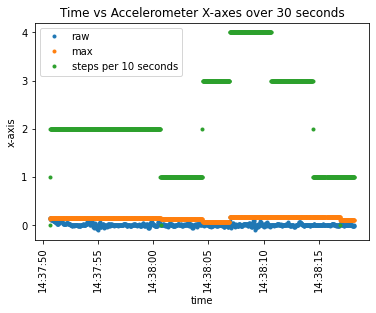

In [36]:
#Test out a few features and plot them.

df =  convert_datetime(pid1_segment_list.copy())[0]
col='x'
df[col+'_max_raw'] = df[col].rolling('10s').max()
# df[col+'_min_raw'] = df[col].rolling('10s').min()
# df[col+'_gait_stretch'] = df[col+'_max_raw'] - df[col+'_min_raw'] 
df[col+'_steps'] = df[col+'_max_raw'].rolling('10s').apply(lambda a: (np.diff(a) != 0).sum().astype(int))

#plot the raw x, max x, and number of steps/maxima in a 10s window
b = df[0:1100]
_=plt.plot(b.index, b.x, '.', b.index, b.x_max_raw,'.', b.index, b.x_steps, '.')
_=plt.legend(['raw', 'max', 'steps per 10 seconds'], loc='best')
_=plt.ylabel('x-axis')
_=plt.xlabel('time')
_=plt.xticks(rotation=90) 
_=plt.title('Time vs Accelerometer X-axes over 30 seconds')

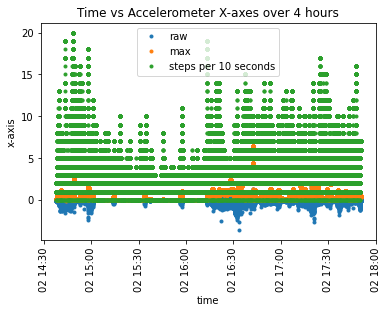

In [37]:
#plot the raw x, max x, and number of steps/maxima in a 10s window, this time over several hours.

b = df

_=plt.plot(b.index, b.x, '.', b.index, b.x_max_raw,'.', b.index, b.x_steps, '.')
#_=plt.plot(b.index, b.x, '.', b.index, b.x_gait_stretch,'.')
_=plt.legend(['raw', 'max', 'steps per 10 seconds'], loc='best')
_=plt.ylabel('x-axis')
_=plt.xlabel('time')
_=plt.xticks(rotation=90) 
_=plt.title('Time vs Accelerometer X-axes over 4 hours')

Initially in our first graph, it seems a bit strange that someone would take only 4 steps in 10 seconds, but when we plot several hours of data, we see that the individual sometimes takes up to 20 steps (possibly they are running, or their cell phone is jostling in their pocket). This variation seems fairly reasonable.

Below, we create several functions to more efficiently featurize the columns of our dataframes.

In [38]:
#Create functions to featurize our columns.

def featurize_column(df, col):
    """Featurizes the dataframe by 10-second windows. Features include mean, std, zero crossing rate, etc.
    Column must be specified (i.e. featurizes from x, y, z, x_tma, y_tma, or z_tma).
    Features are derived from the accelerometer data and not from the TAC columns."""
    
    df[col+'_mean'] = df[col].rolling('10s').mean()
    df[col+'_std'] = df[col].rolling('10s').std()
    df[col+'_median'] = df[col].rolling('10s').median()
    df[col+'_max_raw'] = df[col].rolling('10s').max()
    df[col+'_min_raw'] = df[col].rolling('10s').min()
    df[col+'_max_abs'] = (np.absolute(df[col])).rolling('10s').max()
    df[col+'_min_abs'] = (np.absolute(df[col])).rolling('10s').min()    

    #Zero Crossing Rate
    df[col+'_zcr'] = df[col].rolling('10s').apply(lambda a: (np.diff(np.sign(a)) != 0).sum().astype(int)) 
    
    #Gait stretch - the difference between max and min of one stride.
    df[col+'_gait_stretch'] = df[col+'_max_raw'] - df[col+'_min_raw'] 
    
    #Number of steps - the total number of peaks (maxima) in a window.
    df[col+'_steps'] = df[col+'_max_raw'].rolling('10s').apply(lambda a: (np.diff(a) != 0).sum().astype(int)) 

    #Step Time - average time between steps.
    df[col+'_step_time'] = 10/df[col+'_steps'] #10 second window divided by number of steps
    
    #Root Mean Squared
    df[col+'_rms'] = df[col].rolling('10s').apply(lambda a: np.sqrt(np.mean(a**2)))    
    return df


def avg_resultant_acceleration(df):
    """Calulate the ARA over a 10-second window, using the Root-Mean-Square of each axis.
    Calculates for both raw x, y, z, and for smoothed x_tma, y_tma, z_tma."""
    
    x = df.x_rms.copy()
    y = df.y_rms.copy()
    z = df.z_rms.copy()
    df['xyz_ara'] = np.sqrt(x**2 + y**2 + z**2)
    
    x = df.x_tma_rms.copy()
    y = df.y_tma_rms.copy()
    z = df.z_tma_rms.copy()
    df['xyz_tma_ara'] = np.sqrt(x**2 + y**2 + z**2)
    
    return df


def featurize_df(df):
    """Uses the featurize_column function on each accelerometer column (x, y, z, x_tma, y_tma, and z_tma)"""
    for i in range(len(df)): 
        df[i] = featurize_column(df[i], 'x')
        df[i] = featurize_column(df[i], 'y')
        df[i] = featurize_column(df[i], 'z')
        df[i] = featurize_column(df[i], 'x_tma')
        df[i] = featurize_column(df[i], 'y_tma')
        df[i] = featurize_column(df[i], 'z_tma')
        df[i] = avg_resultant_acceleration(df[i])
    return df

In [39]:
#uncomment the code below to test out the above functions.
#Our resulting df has 85 columns, as expected.
#(we started with 11 col, make 12 new col for each of the original 6 directional col, and made 2 ara columns)

# test = []
# test.append(pid1_dt[0][0:10000].copy())
# test.append(pid1_dt[1][0:10000].copy())
# featurized = featurize_df(test)
# featurized[0].head()

In [ ]:
#Featurize each of the 13 individual's dataframes and export them as CSV files.
#Note: this process can take several hours to run to completion (took me 11 hours with 16 GB ram)
#      As a result, this was only run once to generate the df's which were exported to CSV files.
#      After obtaining our featurized df's, we can just reload them in the first coding box in section 3.4.6.

pid1_featurized = featurize_df(pid1_dt.copy())
pid2_featurized = featurize_df(pid2_dt.copy())
pid3_featurized = featurize_df(pid3_dt.copy())
pid4_featurized = featurize_df(pid4_dt.copy())
pid5_featurized = featurize_df(pid5_dt.copy())
pid6_featurized = featurize_df(pid6_dt.copy())
pid7_featurized = featurize_df(pid7_dt.copy())
pid8_featurized = featurize_df(pid8_dt.copy())
pid9_featurized = featurize_df(pid9_dt.copy())
pid10_featurized = featurize_df(pid10_dt.copy())
pid11_featurized = featurize_df(pid11_dt.copy())
pid12_featurized = featurize_df(pid12_dt.copy())
pid13_featurized = featurize_df(pid13_dt.copy())

In [ ]:
# Change each list of df's into a single df, in order to export it as a single CSV file.

def recombine_data(df_list):
    """Does the opposite of function 'segment_data()', by recombining the list of df's into a single df."""
    
    df_combined = df_list[0].copy() #the first segment is converted to a df

    for i in range(len(df_list)-1): #-1 to account for already having the first segment
        df_combined = df_combined.append(df_list[i+1])

    return df_combined

#Check to see if this works on pid1_featurized, which only has 2 segments.
test = pid1_featurized.copy()
combine_test = recombine_data(test)
print(test[0].shape)
print(test[1].shape)
print(combine_test.shape)

In [ ]:
#Recombine the df's

pid1_featurized_combined = recombine_data(pid1_featurized.copy())
pid2_featurized_combined = recombine_data(pid2_featurized.copy())
pid3_featurized_combined = recombine_data(pid3_featurized.copy())
pid4_featurized_combined = recombine_data(pid4_featurized.copy())
pid5_featurized_combined = recombine_data(pid5_featurized.copy())
pid6_featurized_combined = recombine_data(pid6_featurized.copy())
pid7_featurized_combined = recombine_data(pid7_featurized.copy())
pid8_featurized_combined = recombine_data(pid8_featurized.copy())
pid9_featurized_combined = recombine_data(pid9_featurized.copy())
pid10_featurized_combined = recombine_data(pid10_featurized.copy())
pid11_featurized_combined = recombine_data(pid11_featurized.copy())
pid12_featurized_combined = recombine_data(pid12_featurized.copy())
pid13_featurized_combined = recombine_data(pid13_featurized.copy())

In [ ]:
#pid3 is the df with most segments (22). Check to see it's properly combined.
print(len(pid3_featurized_combined)) #should not be 22 anymore
print(type(pid3_featurized_combined))

In [ ]:
# Save each pid##_featurized df into a CSV file.

pid1_featurized_combined.to_csv('pid1_featurized.csv')
pid2_featurized_combined.to_csv('pid2_featurized.csv')
pid3_featurized_combined.to_csv('pid3_featurized.csv')
pid4_featurized_combined.to_csv('pid4_featurized.csv')
pid5_featurized_combined.to_csv('pid5_featurized.csv')
pid6_featurized_combined.to_csv('pid6_featurized.csv')
pid7_featurized_combined.to_csv('pid7_featurized.csv')
pid8_featurized_combined.to_csv('pid8_featurized.csv')
pid9_featurized_combined.to_csv('pid9_featurized.csv')
pid10_featurized_combined.to_csv('pid10_featurized.csv')
pid11_featurized_combined.to_csv('pid11_featurized.csv')
pid12_featurized_combined.to_csv('pid12_featurized.csv')
pid13_featurized_combined.to_csv('pid13_featurized.csv')

Now that we have featurized our data, we can investigate any relationships between our features.

### 3.4.6 Investigating Features<a id='3.4.6_Investigating_Features'></a>

In [3]:
#Because the featurizing process in section 3.4.5 is quite time consuming, after we run it once, 
#we can simply uncomment the code below to read the featurized df's we already have. 
#We need not re-run the entire notebook.

# pid1_featurized = pd.read_csv('pid1_featurized.csv')
# pid2_featurized = pd.read_csv('pid2_featurized.csv')
# pid3_featurized = pd.read_csv('pid3_featurized.csv')
# pid4_featurized = pd.read_csv('pid4_featurized.csv')
# pid5_featurized = pd.read_csv('pid5_featurized.csv')
# pid6_featurized = pd.read_csv('pid6_featurized.csv')
# pid7_featurized = pd.read_csv('pid7_featurized.csv')
# pid8_featurized = pd.read_csv('pid8_featurized.csv')
# pid9_featurized = pd.read_csv('pid9_featurized.csv')
# pid10_featurized = pd.read_csv('pid10_featurized.csv')
# pid11_featurized = pd.read_csv('pid11_featurized.csv')
# pid12_featurized = pd.read_csv('pid12_featurized.csv')
# pid13_featurized = pd.read_csv('pid13_featurized.csv')

When investigating our features, we need to take into consideration whether our variables are categorical or continuous. Our features are continuous (mean, median, std, zero crossing rate, RMS, ...) but our dependent variable could either be interpreted as continuous (blood alcohol concentration ranging from 0% up to around 40%) or categorical (below 8% BAC, or equal to or higher than 8% BAC). 

If we consider the dependent variable as continuous, we can examine any relations via scatterplots or a correlation heatmap. Furthermore, we can do a Principal Component Analysis and see how much each feature contributes to the variability of the dependent variable.

If we consider the dependent variable as categorical, we can examine distributions of the features as various distributions such as boxplots. 

In both of these cases, we need to remember to scale our data.

In [4]:
#From here on, we will explore in depth just 1 of our 13 datasets.
#Note that I've selected pid3. This is becaues they have the largest number of rows.
#But we can easily change it to any other pid# and explore that set instead.

#Note: we can change this to any other df we want to look at, and re-run the code below.
df = pid3_featurized.set_index('time').copy() 
#df = pid3_featurized_combined.copy()

df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0) #drop any infinite of nan values

y_cols = ['order_3', 'order_5', 'order_7', 'order_9', 'tma'] #these are our dependent variable, the TAC data
y = df[y_cols]
X = df.drop(columns = y_cols)

In [5]:
#Scale the data, using the previously imported "from sklearn.preprocessing import scale"
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [6]:
#Let's check the shape. We should expect 80 columns and more than 1 million rows.
X_scaled.shape

(1656973, 80)

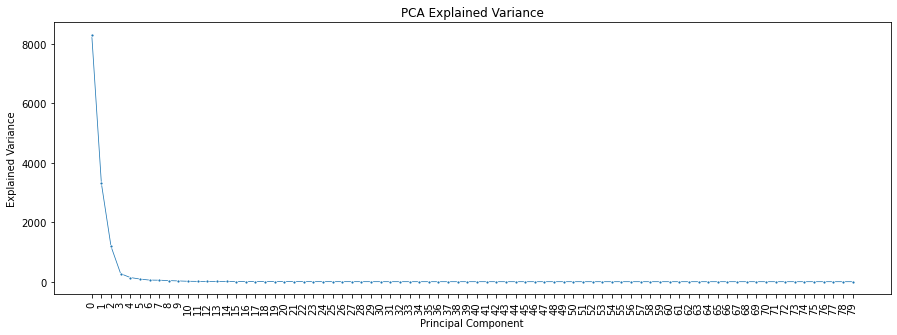

In [7]:
#Now that we have our scaled features, let's initialiez a PCA
#and see how our 80 features contribute to the variance.

pca = PCA()
pca.fit(X)

fig, ax = plt.subplots(figsize=(15,5))
y_pca = pca.explained_variance_
x_pca = np.arange(len(y_pca))
_=sns.lineplot(x_pca,y_pca, marker='.', size=20, legend=False)
_=plt.ylabel('Explained Variance')
_=plt.xlabel('Principal Component')
_=plt.title('PCA Explained Variance')
_=plt.xticks(np.arange(len(y_pca)), rotation=90)

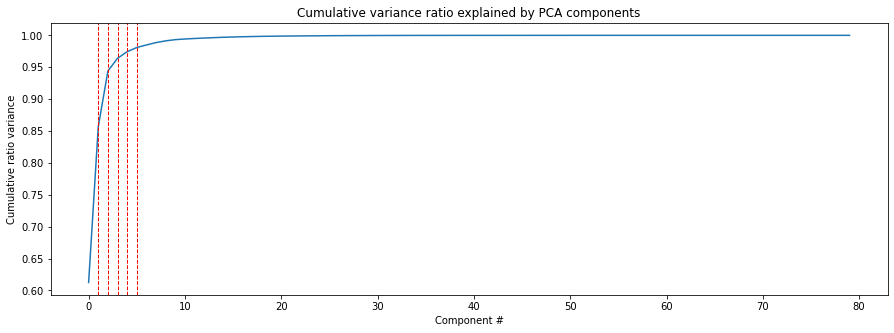

In [8]:
_=plt.subplots(figsize=(15, 5))
_=plt.plot(pca.explained_variance_ratio_.cumsum())
_=plt.xlabel('Component #')
_=plt.ylabel('Cumulative ratio variance')
_=plt.title('Cumulative variance ratio explained by PCA components')

_=plt.axvline(1, linewidth=1, color='r', linestyle='--')
_=plt.axvline(2, linewidth=1, color='r', linestyle='--')
_=plt.axvline(3, linewidth=1, color='r', linestyle='--')
_=plt.axvline(4, linewidth=1, color='r', linestyle='--')
_=plt.axvline(5, linewidth=1, color='r', linestyle='--')

C:\Users\grace\anaconda3\envs\TestEnv7\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-50-a5300080e555>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_categorized.loc[(y_categorized.order_3 >= 0.08),:] = 1
<ipython-input-50-a5300080e555>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_categorized.loc[(y_categorized.order_3 < 0

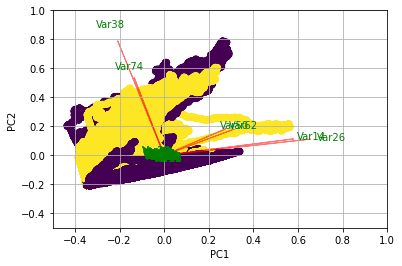

In [50]:
#Below is code to plot a PCA biplot, adapted from the author Serafeim Loukas of the following article:
# https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e

pca = PCA()
x_new = pca.fit_transform(X)

#Color-code the points by categorizing one column in y as >= 8% TAC or <8%
y_categorized = y[['order_3']]
y_categorized.loc[(y_categorized.order_3 >= 0.08),:] = 1
y_categorized.loc[(y_categorized.order_3 < 0.08),:] = 0

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y_categorized.order_3)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-0.5,1)
plt.ylim(-0.5,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.

myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

From our PCA, we can see that the first 3 components already explain more than 95% of the variance of our dataset. If we look at the graph of explained variance, and use the "elbow method", we see the steepness of the curve drastically decrease after component 3.

If we take a look at our first two components plotted as a biplot, due to the great overlap between the categories of >= 0.08 TAC and < 0.08 TAC, it's not clear whether there is a clear pattern between the components and whether someone is legally intoxicated or not. We can explore this further in our next notebook, when we do some feature engineering and find feature importance in some preliminary random forest models.

Below we look at the correlation heatmap of our dataframe.

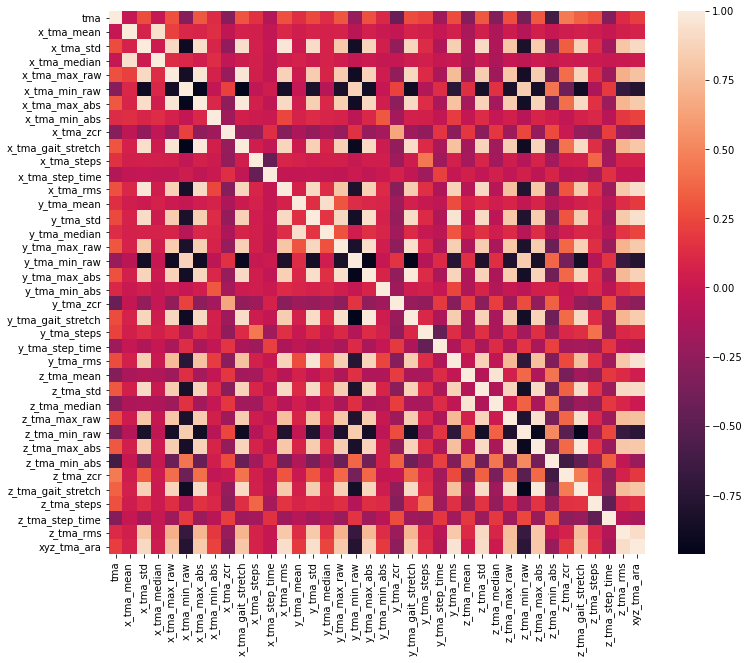

In [9]:
#Since it's a bit overwhelming and not visually useful to visualize 85 columns, we should narrow it down.
#Let's look only at the data from the smoothed tma (triangular moving average), and drop the raw accelerometer data.

tma_col = ['tma', 'x_tma_mean',
       'x_tma_std', 'x_tma_median', 'x_tma_max_raw', 'x_tma_min_raw',
       'x_tma_max_abs', 'x_tma_min_abs', 'x_tma_zcr', 'x_tma_gait_stretch',
       'x_tma_steps', 'x_tma_step_time', 'x_tma_rms', 'y_tma_mean',
       'y_tma_std', 'y_tma_median', 'y_tma_max_raw', 'y_tma_min_raw',
       'y_tma_max_abs', 'y_tma_min_abs', 'y_tma_zcr', 'y_tma_gait_stretch',
       'y_tma_steps', 'y_tma_step_time', 'y_tma_rms', 'z_tma_mean',
       'z_tma_std', 'z_tma_median', 'z_tma_max_raw', 'z_tma_min_raw',
       'z_tma_max_abs', 'z_tma_min_abs', 'z_tma_zcr', 'z_tma_gait_stretch',
       'z_tma_steps', 'z_tma_step_time', 'z_tma_rms', 'xyz_tma_ara']
plt.subplots(figsize=(12,10))
sns.heatmap(df[tma_col].corr());

Looking at the heatmap, we want to see if the column labeled "tma" (i.e. the Transdermal Alcohol Content, smoothed by a triangular moving average of window size 3 (1.5 hours)), whether "tma" is correlated with any of the other variables.

At a quick glance, we can see that "tma" is very negatively correlated with "z_tma_min_abs", or the minimum of the absolute value of the accelerometer data in the z-axis on a 10-second window. This seems to imply that as the blood alcohol content (BAC) of the participant increases, the participant has smaller minima in the cell phone accelerometer z-axis, perhaps indicating less movement. There is also a negative correlation with the y-axis zero crossing rate "y_tma_zcr" and a slight positive correlation with the z-axis zero crossing rate "z_tma_zcr", which implies a change in directional movement as BAC increases (i.e. possibly the participant moves more frequently in the z-axis direction and less so in the y-axis as they increase in their BAC).

Below we look at scatterplots of the scaled data. We can use the seaborn's pairplot to see how each feature varies with one another.

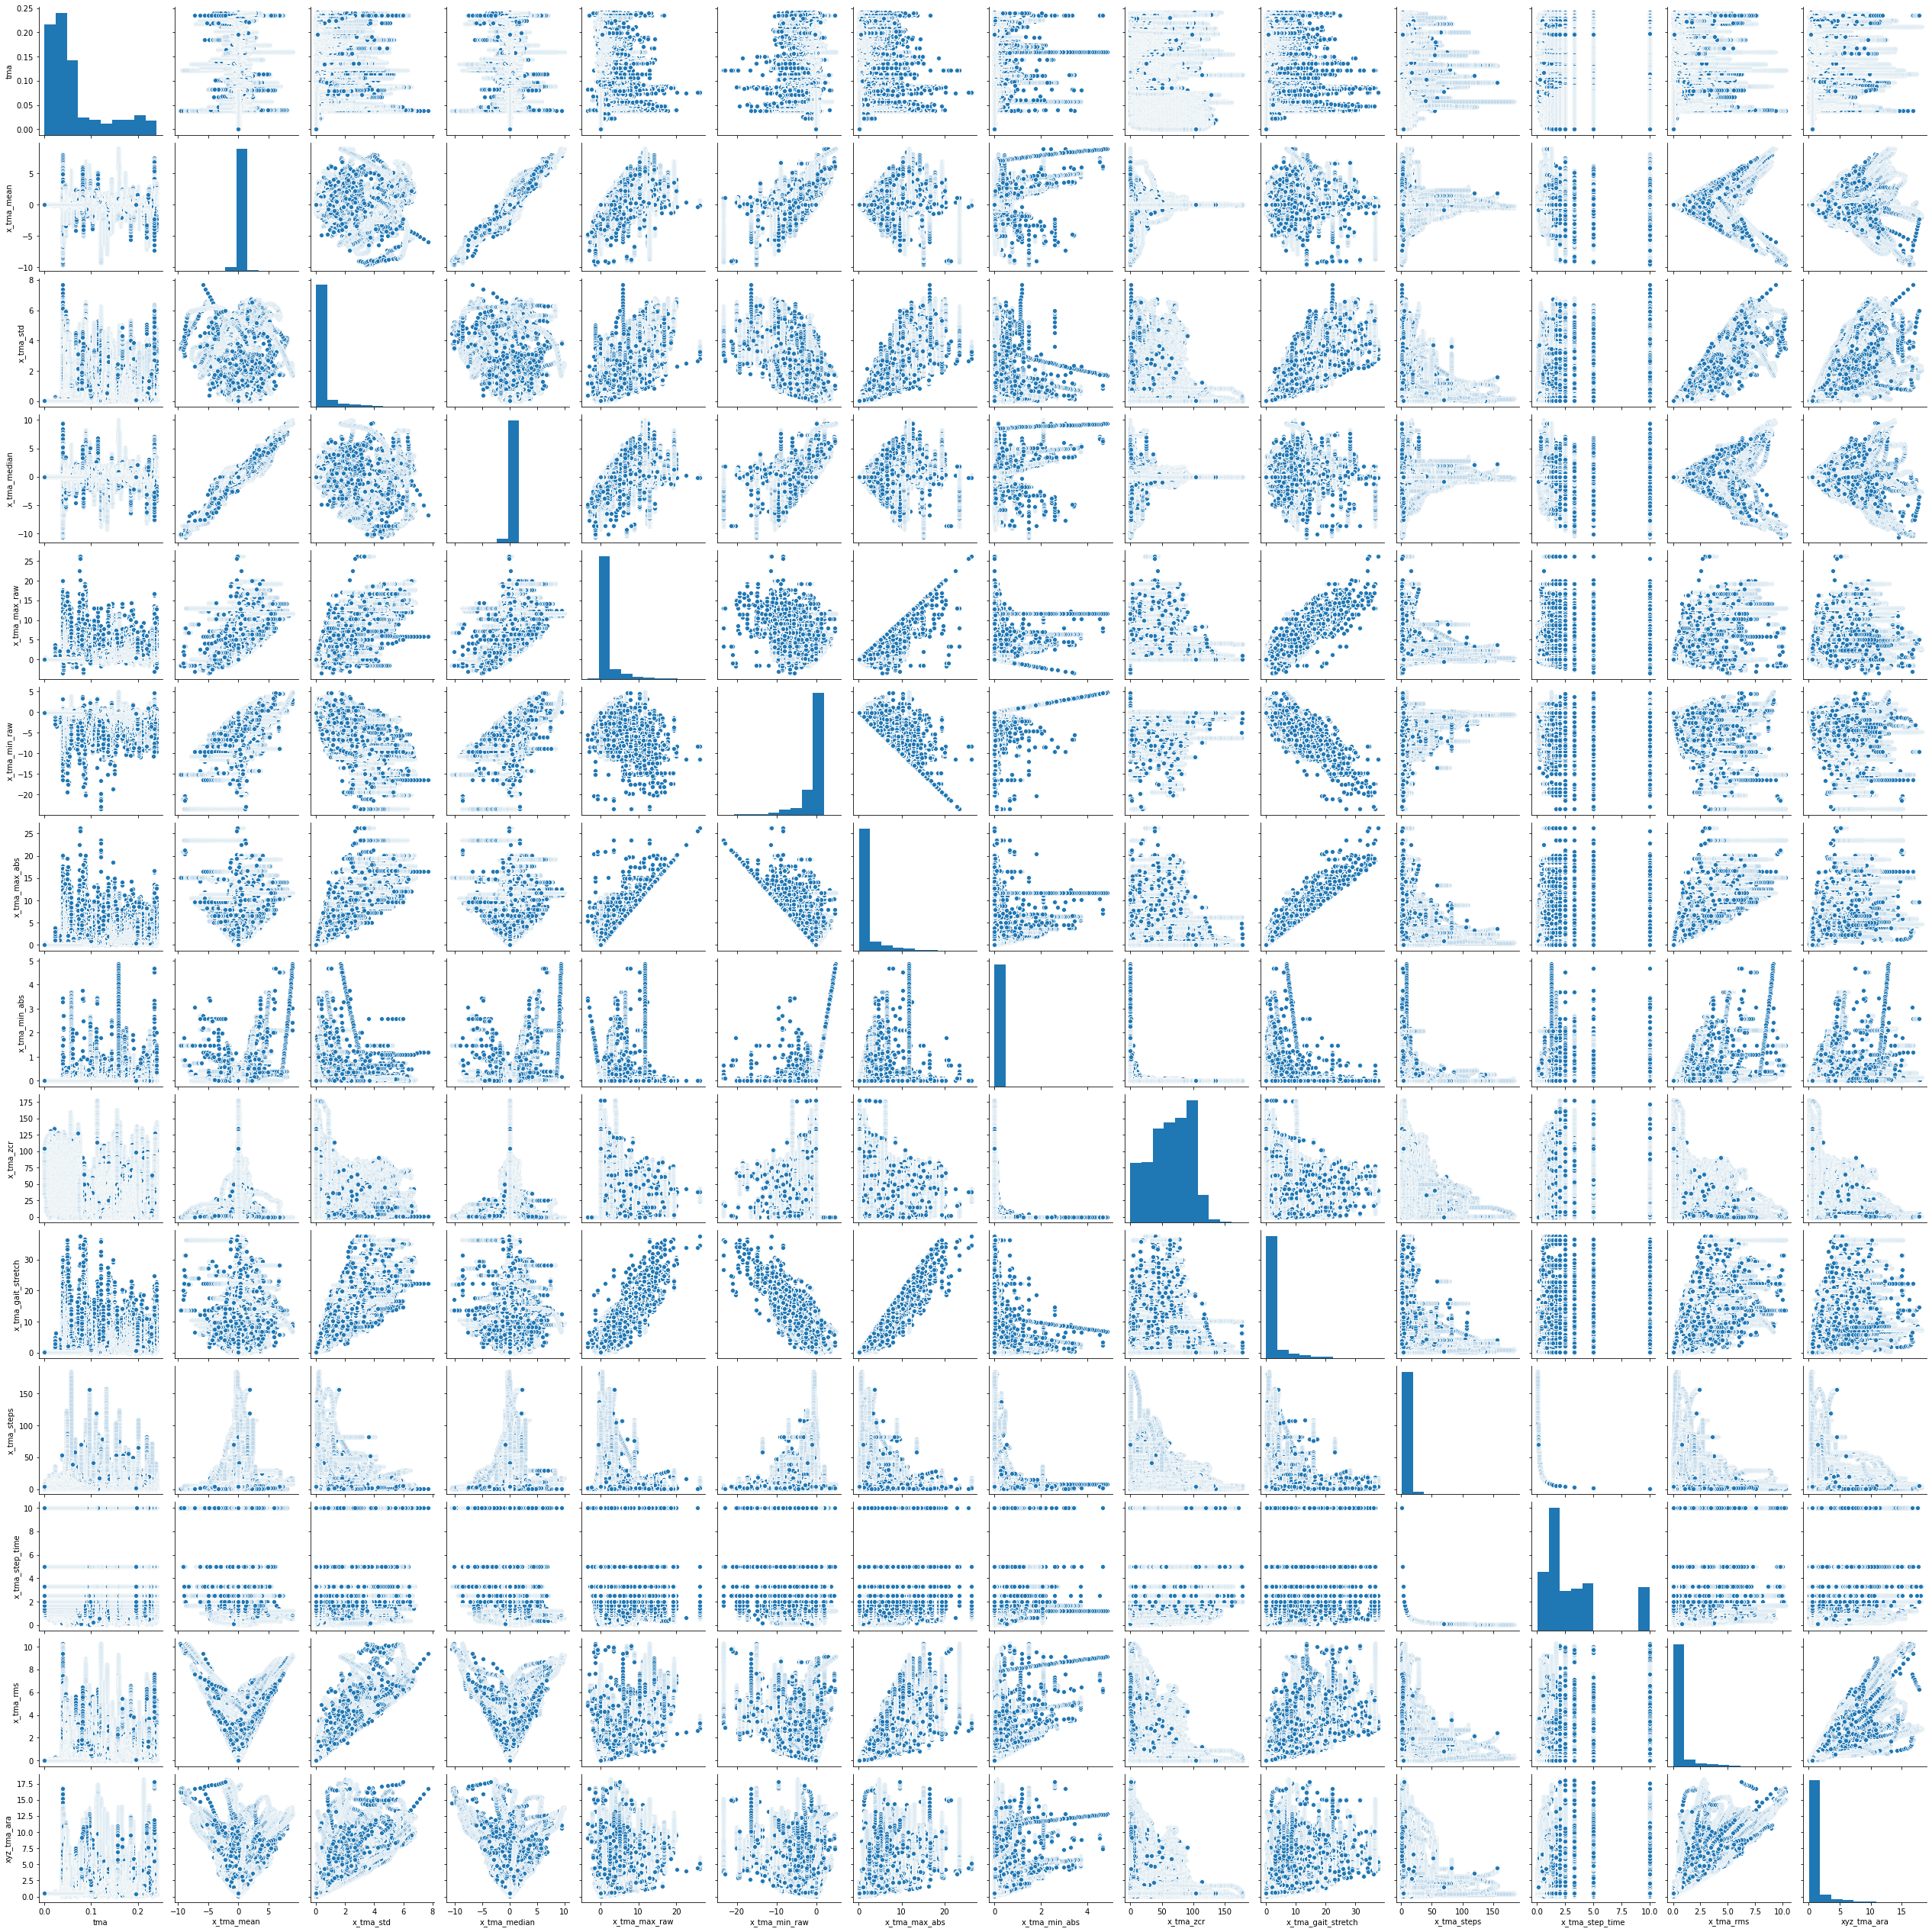

In [10]:
#Like before for the heatmap, let's look only at the tma data.
#Because we have 1.6 million rows from pid3, running pairplot can cause us to run out of memory.
#Instead, let's run a small subset, looking only at the x-axis features.

x_tma_col = ['tma', 'x_tma_mean',
       'x_tma_std', 'x_tma_median', 'x_tma_max_raw', 'x_tma_min_raw',
       'x_tma_max_abs', 'x_tma_min_abs', 'x_tma_zcr', 'x_tma_gait_stretch',
       'x_tma_steps', 'x_tma_step_time', 'x_tma_rms','xyz_tma_ara']

sns.pairplot(df[x_tma_col])

Looking at the seaborn pairplot, the series of plots we want to focus on are the ones relating to "tma", i.e. the TAC data. Unfortunately, it does not appear to have a clear correlation with any of the features shown. Knowing this, we could see that methods like linear regression would not be suitable, and rather we would want to use somthing like a Random Forest model.

Finally, let's take a look at some boxplots to visualize the distribution of our data, grouped by the TAC data as a categorical variable (1 for BAC >= 8%, 0 for <8%).

In [52]:
#Similarly to before, let's look only at one of axes features.

#select just one of the dependent variables, and convert it into categorical.
df_boxplot = df[x_tma_col].copy()
df_boxplot_drunk = df_boxplot.loc[(df_boxplot.tma >= 0.08)]
df_boxplot_sober = df_boxplot.loc[(df_boxplot.tma < 0.08)]

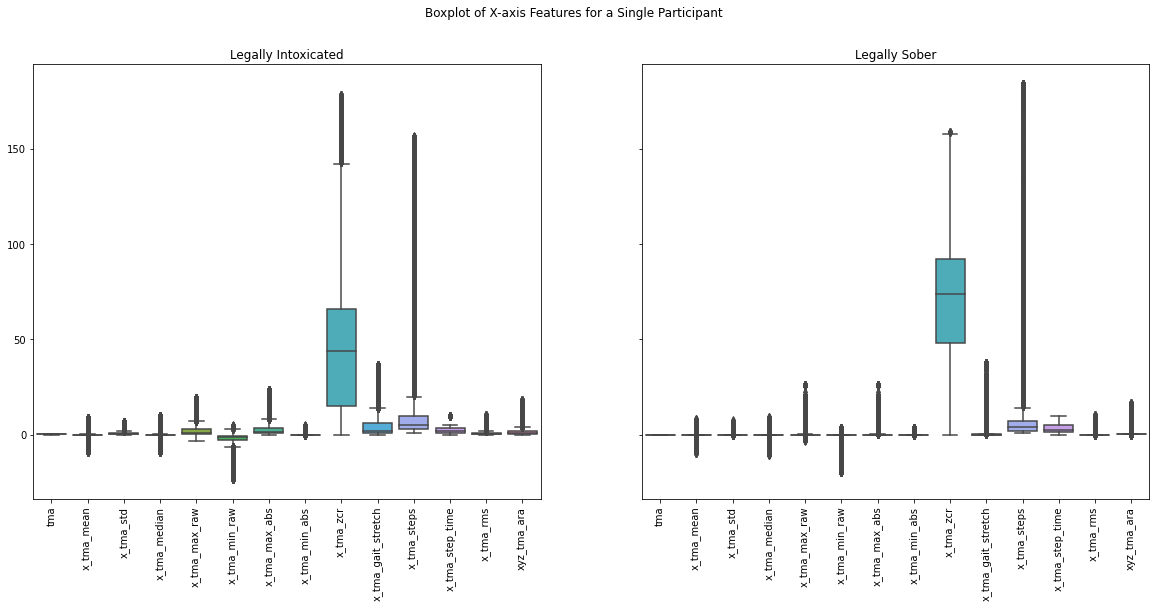

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
fig.suptitle('Boxplot of X-axis Features for a Single Participant')

sns.boxplot(ax=axes[0], data = df_boxplot_drunk)
axes[0].set_title('Legally Intoxicated')
axes[0].set_xticklabels(df_boxplot_drunk.columns,rotation=90)

sns.boxplot(ax=axes[1], data = df_boxplot_sober)
axes[1].set_title('Legally Sober');
axes[1].set_xticklabels(df_boxplot_drunk.columns,rotation=90);

Comparing the drunk and sober boxplots, we can see that in the sober data, the interquartile range for most features is smaller than that of the drunk features. This seems to imply that here is more variation in movement for the drunk individual.

### 3.5 Summary and Next Steps<a id='3.5_Summary_and_Next_Steps'></a>

__Summary of the Notebook:__

* We shifted the TAC data (subtracted the 45-minute lag between blood alcohol content and detection of transdermal alcohol content) in order to align the accelerometer data with the changes in the TAC.
* We imputed the missing TAC data in two ways, generating multiple sets of TAC data. 
 * In the first method, we interpolated with a polynomial fitting on the 3rd, 5th, 7th, and 9th orders. 
 * In the second method, we smoothed the TAC data first with a triangular moving average of window size 3 (1.5 hours, as each TAC datapoint is measured per 30 minutes), followed by interpolation with a 3rd order polynomial fitting. We also used a triangular moving average to make a smoothed set of the accelerometer data.
* We segmented the data into sections separated by 2 minutes or more of missing readings. Then we featurized the data, recombined it, and exported each dataframe as a CSV file.
* We made the following features in 6-fold sets (x, y, and z axis, plus their smoothed counterparts x_tma, y_tma, and z_tma) using the pandas rolling() method over 10-second windows:
 * Mean
 * Standard Deviation
 * Median
 * Zero Crossing Rate
 * Max (of raw and of absolute signal)
 * Min (of raw and of absolute signal)
 * Gait stretch - the difference between max and min of one stride (of raw signal).
 * Number of steps
 * Step Time - the average time between steps.
 * Root-mean-square of accelerations
 * Average Resultant Acceleration
* We investigated relationships between features using PCA, correlation heatmaps, scatterplots, histograms, and boxplots.
 * From PCA, we learned that only the first 3 components from PCA contribute to more than 95% of the variance. But when we looked at the biplot of the first 2 components, there does not appear to have a clear visual distinction between the characteristics of the participant when they are legally drunk versus when they are legally sober.
 * From the correlation heatmaps, scatterplots, histograms, and boxplots, there does not appear to be an obvious relationship between any of the features and the participant's Transdermal Alcohol Content. However, there visually appears in the boxplots to be less variation in the features for the participant when they are sober compared to when they are intoxicated.
 * This investigation indicates we may want to generate more features (such as the standard deviation of our features, or changes of our features over time, etc.) that would help us to better predict whether someone would become intoxicated or not based on their phone accelerometer data.

__Next Steps:__

When invesigating our features, we learned that there may be some benefit to developing even more features. In the next notebook, we can use the featuretools library to help us generate more features. We should still keep in mind though that given our large datasets (many with over 1 million rows), trying to learn off of many features may be unfeasible and we may want to look into PCA to simplify our datasets prior to doing ML.

We also saw from the seaborn pairplot that there was no feature with a clear correlation with alcohol level. Rather than trying a method like linear regression, we should start with Random Forest (in fact, we can use RF as a baseline, since this was found to be the best method by the authors of the paper), followed by XG Boost and possibly other models.

In [ ]:
#Update 12/04/2020

#This code block was originally in section 3.4.2 Smoothing the Data. It is kept here as a reminder.

#Note 3: Pandas dataframes are heavier than numpy arrays. It is important to keep this in mind
# when working with large dataframes. In the course of this notebook we have learned it is not
# feasibly to manipulate a pandas df that spans hundreds of thousands of rows.

#Note 1: I originally wrote the code such that I merged the original df columns onto the new interpolated df,
# (left merge, on "time" column), but when I tried plotting the new TAC_interpolate, it crashed the computer.
# To avoid this happening again, the smoothing method only returns a 2-column dataframe with no NaNs:
# the "time" column and the smoothed TAC column.

#Note 2: interpolating such that every df has time with step size 1 millisecond results in long dataframes
# (on the order of 100 million entries) that require up to 1.9 GB memory. This is unsustainable
# if we want to make 6 df's per individual, or total of 78 df's (1 df for TMA, and 5 for polynomial fitting
# for degree = [3,7]. We need to rewrite again so we keep just the accelerometer entries and their
# smoothed TAC entries.

#Define the two smoothing functions

# def polynomial_smooth(df, col_name = 'TAC_shifted', order=2):
#     """Smooths the TAC_shifted column using a polynomial fitting to interpolate all NaN values.
#     Returns a 2-column dataframe: time and TAC values (labeled "time" and "TAC_interpolate", respectively). 
#     Polynomial fitting requires that you must specify an order. The default order is 2."""
    
#     # Create a dataframe with all the timepoints in the df, with the time column interpolated with step size 1.
#     df_raw = df[['time', col_name]].dropna()
    
#     start_time = df_raw.time.min()
#     end_time = df_raw.time.max()
#     time_interpolate = np.arange(start_time, end_time+1, step=1) #time column has step size 1 millisecond
#     df_time_interpolate = pd.DataFrame(data={'time':time_interpolate})

#     #merge the TAC values onto this new time col.
#     df_merged = pd.merge(df_time_interpolate, df_raw, how='left', on='time') 
    
#     #interpolate the missing column values.
#     df_interpolate = df_merged.interpolate(method='polynomial', order=order)
#     df_renamed = df_interpolate.rename(columns={col_name: "TAC_interpolate"}) #rename the column
    
#     df_acc = df[['time', 'x', 'y', 'z']]

#     #merge the original df column values onto this new interpolated df. Drop the NaN values.
#     df_interpolate_merged = pd.merge(df_acc, df_renamed, how='left', on='time')
#     df_sorted = df_interpolate_merged.sort_values(by='time').reset_index(drop=True)

#     return df_sorted

# def tma_smooth(df, col_name = 'TAC_shifted', window=3):
#     """Smooths the TAC_shifted column using a triangular moving average (TMA), default window size 3. 
#     This is followed by an interpolation of a linear fitting."""
#  ####fix this!!!   
#     triang = pid3_shift.TAC_shifted.rolling(3, center=True, win_type='triang').mean()
#     df_triang = pd.DataFrame(data={'time':pid3_shift.time, 'triang':triang})
#     triang_poly = df_triang.sort_values(by='time').reset_index(drop=True).interpolate(method='linear')
    
#     return df_tma_quadratic